FB Case study

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os


import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [18]:
%%time
train_csv=pd.read_csv('train.csv')
print(train_csv[train_csv.isna().any(1)])
print(train_csv.info())
print('number of duplicate entries',sum(train_csv.duplicated()))
train_csv1=pd.read_csv('train.csv',nrows=1000000)
train_csv1.to_csv('train1.csv',index=False)#concided data to 1m points for speeding on my device with 4 gigs ram
train_csv1.to_csv('train_woheader.csv',header=False,index=False)
print("saved the graph into file")


train_csv.head()


Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB
None
number of duplicate entries 0
saved the graph into file
Wall time: 23.3 s


In [19]:
%%time
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 685775
Number of edges: 1000000
Average in degree:   1.4582
Average out degree:   1.4582
Wall time: 14.1 s


In [4]:
pd.read_csv('train_woheader.csv',nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(subgraph))


Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


C:\Users\kranti\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\kranti\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\Users\kranti\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\Users\kranti\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb

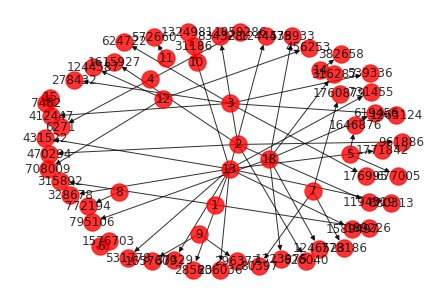

In [5]:
import matplotlib.pylab as plt
q=nx.spring_layout(subgraph)
nx.draw(subgraph,q,node_color='red',edge_color='black',width=1,edge_cmap=plt.cm.Blues,with_labels=True,alpha=0.8)
plt.savefig('graph_sample.jpg')

In [6]:
print('number of connections',len(g.edges()))
print('number of unique users',len(g.nodes()))


number of connections 1000000
number of unique users 685775


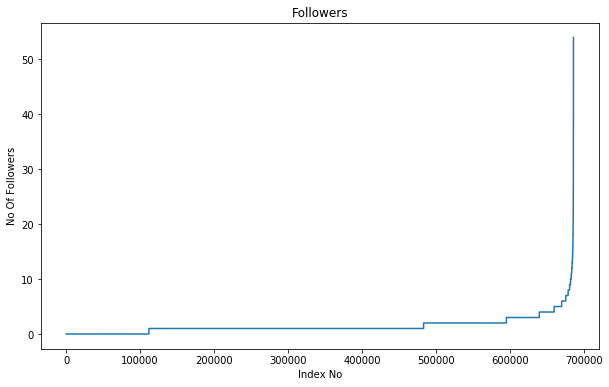

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.title('Followers')
plt.show()

In [8]:
for i in range(90,101,1):
    print(i,' percentile value is:',np.percentile(indegree_dist,i))

90  percentile value is: 3.0
91  percentile value is: 3.0
92  percentile value is: 3.0
93  percentile value is: 3.0
94  percentile value is: 4.0
95  percentile value is: 4.0
96  percentile value is: 4.0
97  percentile value is: 5.0
98  percentile value is: 6.0
99  percentile value is: 8.0
100  percentile value is: 54.0


In [9]:
for i in range(0,101,10):
    j=99+(i/100)
    print(j,'percentile value is:',np.percentile(indegree_dist,j))

99.0 percentile value is: 8.0
99.1 percentile value is: 8.0
99.2 percentile value is: 8.0
99.3 percentile value is: 9.0
99.4 percentile value is: 9.0
99.5 percentile value is: 10.0
99.6 percentile value is: 11.0
99.7 percentile value is: 12.0
99.8 percentile value is: 14.0
99.9 percentile value is: 17.0
100.0 percentile value is: 54.0


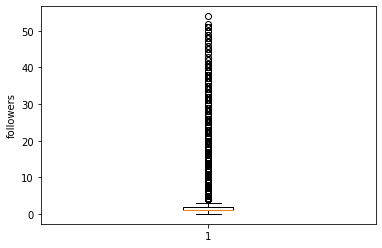

In [10]:
plt.boxplot(indegree_dist)
plt.ylabel('followers')
plt.show()

C:\Users\kranti\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


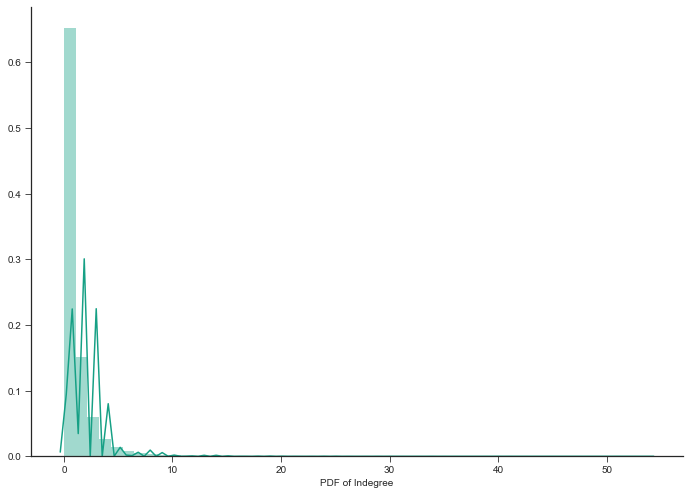

In [11]:
#%matplotlib inline

sns.set_style('ticks')
fig,ax=plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist,color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

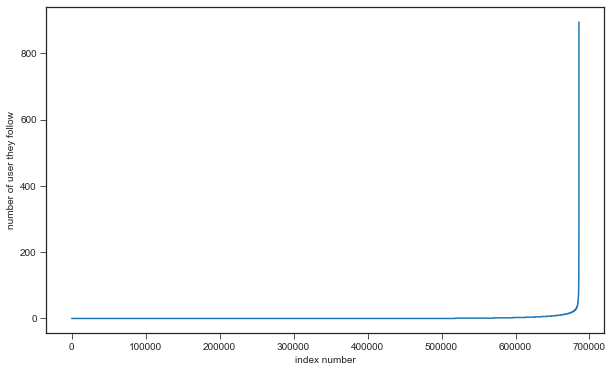

In [12]:
outdegree_dist=list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('index number')
plt.ylabel('number of user they follow')
plt.show()

In [13]:
for i in range(90,101,1):
    print(i,' percentile value is:',np.percentile(outdegree_dist,i))

90  percentile value is: 4.0
91  percentile value is: 4.0
92  percentile value is: 5.0
93  percentile value is: 6.0
94  percentile value is: 7.0
95  percentile value is: 8.0
96  percentile value is: 10.0
97  percentile value is: 12.0
98  percentile value is: 16.0
99  percentile value is: 23.0
100  percentile value is: 895.0


In [14]:
for i in range(0,101,10):
    j=99+(i/100)
    print(j,'percentile value is:',np.percentile(outdegree_dist,j))

99.0 percentile value is: 23.0
99.1 percentile value is: 24.0
99.2 percentile value is: 25.0
99.3 percentile value is: 27.0
99.4 percentile value is: 29.0
99.5 percentile value is: 31.0
99.6 percentile value is: 34.90399999998044
99.7 percentile value is: 39.0
99.8 percentile value is: 48.0
99.9 percentile value is: 68.0
100.0 percentile value is: 895.0


C:\Users\kranti\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


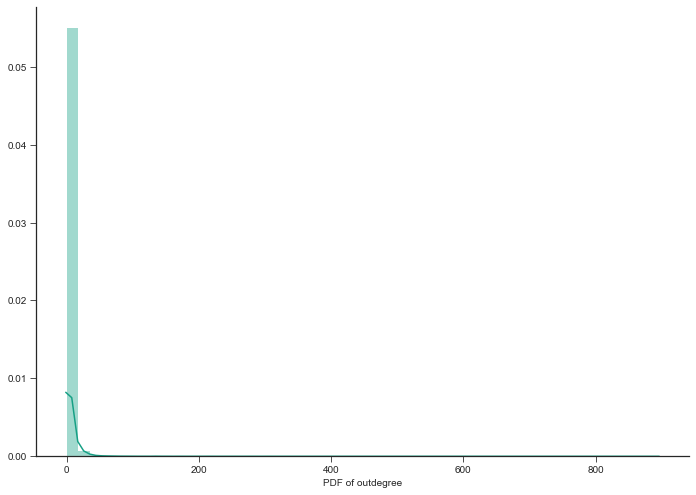

In [15]:
sns.set_style('ticks')
fig,ax=plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist,color='#16A085')
plt.xlabel('PDF of outdegree')
sns.despine()
#plt.show()

In [16]:
print('number of users that dont follow anyone is:',sum(np.array(outdegree_dist)==0))
print('percentage of users that dont follow anyone is:',((sum(np.array(outdegree_dist)==0)/len(outdegree_dist))*100))


number of users that dont follow anyone is: 518757
percentage of users that dont follow anyone is: 75.6453647333309


In [17]:
print('number of users that dont have followers:',sum(np.array(indegree_dist)==0))
print('percentage of users that dont have followers:',((sum(np.array(indegree_dist)==0)/len(indegree_dist))*100))


number of users that dont have followers: 111814
percentage of users that dont have followers: 16.304764682293754


In [18]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


In [19]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

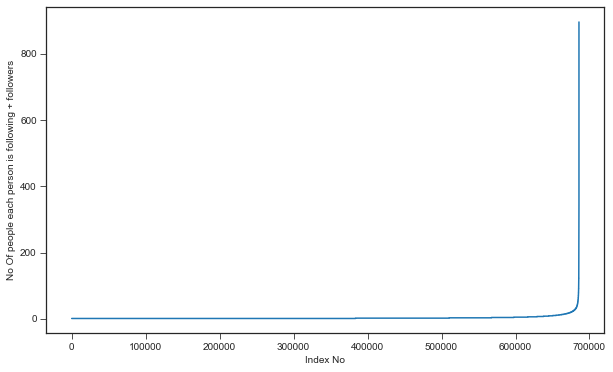

In [20]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [21]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 6.0
91 percentile value is 6.0
92 percentile value is 7.0
93 percentile value is 7.0
94 percentile value is 8.0
95 percentile value is 10.0
96 percentile value is 11.0
97 percentile value is 14.0
98 percentile value is 18.0
99 percentile value is 25.0
100 percentile value is 896.0


In [22]:
for i in range(0,101,10):
    j=99+(i/100)
    print(j,'percentile value is:',np.percentile(in_out_degree_sort,j))

99.0 percentile value is: 25.0
99.1 percentile value is: 27.0
99.2 percentile value is: 28.0
99.3 percentile value is: 30.0
99.4 percentile value is: 32.0
99.5 percentile value is: 35.0
99.6 percentile value is: 38.0
99.7 percentile value is: 44.0
99.8 percentile value is: 53.0
99.9 percentile value is: 74.22600000002421
100.0 percentile value is: 896.0


In [23]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
383622  persons having minimum no of followers + following


In [24]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 896
1  persons having maximum no of followers + following


In [25]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 650278


In [26]:
print('number of weakly connected components',len(list(nx.weakly_connected_components(g))))

number of weakly connected components 42096


In [27]:
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with only 2 nodes:',count)

weakly connected components with only 2 nodes: 24994


In [31]:
%%time
if os.path.isfile('missing_edges_final.p'):
    missingedges = pickle.load(open('missing_edges_final.p','rb'))
else:
    import random
    r=csv.reader(open('train_woheader.csv','r'))
    edges=dict()
    for edge in r:
        edges[(edge[0],edge[1])]=1
    
    missingedges=set([])

    while (len(missingedges)<1000000):
        a=random.randint(1,1000000)
        b=random.randint(1,1000000)
        x=edges.get((a,b),0)
        if x==0 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2:
                    missingedges.add((a,b))
                else:
                    continue  
            except:  
                 missingedges.add((a,b)) 
        else:
            continue
    pickle.dump(missingedges,open('missing_edges_final.p','wb'))

    print(len(missingedges))
    

Wall time: 429 ms


In [30]:
TRAIN TEST DATA Split

SyntaxError: invalid syntax (<ipython-input-30-9c7cc46abe71>, line 1)

In [32]:
data_pos=pd.read_csv('train1.csv')
data_neg=pd.DataFrame(list(missingedges),columns=['source_node','destination_node'])
print("Number of nodes in the graph with edges", data_pos.shape[0])
print("Number of nodes in the graph without edges", data_neg.shape[0])
data_pos.head()
data_neg.head()

Number of nodes in the graph with edges 1000000
Number of nodes in the graph without edges 1000000


,source_node,destination_node
0,922968,613267
1,353945,804368
2,196965,751083
3,692402,843046
4,102083,395100


In [33]:
from sklearn.model_selection import train_test_split
x_train_pos,x_test_pos,y_train_pos,y_test_pos = train_test_split(data_pos,np.ones(len(data_pos)),test_size=0.2,random_state=9)
x_train_neg,x_test_neg,y_train_neg,y_test_neg = train_test_split(data_neg,np.zeros(len(data_neg)),test_size=0.2,random_state=9)
print('='*60)

print("Number of nodes in the train data graph with edges", x_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", x_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", x_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", x_test_neg.shape[0],"=",y_test_neg.shape[0])


Number of nodes in the train data graph with edges 800000 = 800000
Number of nodes in the train data graph without edges 800000 = 800000
Number of nodes in the test data graph with edges 200000 = 200000
Number of nodes in the test data graph without edges 200000 = 200000


# STORING TRAIN TEST DATA SEPERATELY

In [34]:
x_train_pos.to_csv('x_train_pos_after_eda.csv',header=False,index=False)
x_test_pos.to_csv('x_test_pos_after_eda.csv',header=False,index=False)
x_train_neg.to_csv('x_train_neg_after_eda.csv',header=False,index=False)
x_test_neg.to_csv('x_test_neg_after_eda.csv',header=False,index=False)



In [ ]:
#del missingedges


In [21]:
train_graph=nx.read_edgelist('x_train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)


In [37]:
print(nx.info(train_graph))


Name: 
Type: DiGraph
Number of nodes: 603211
Number of edges: 800000
Average in degree:   1.3262
Average out degree:   1.3262


In [38]:
test_graph=nx.read_edgelist('x_test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(test_graph))


Name: 
Type: DiGraph
Number of nodes: 241514
Number of edges: 200000
Average in degree:   0.8281
Average out degree:   0.8281


In [39]:
train_set=set(train_graph.nodes())
test_set=set(nx.nodes(test_graph))
print('number of common nodes in train and set data:',len(train_set.intersection(test_set)))
print('number of nodes not there in test but in train data:',len(train_set-test_set))
print('number of nodes not there in train but in test data:',len(test_set-train_set))
print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(len(test_set-train_set)/len(test_set)*100))

number of common nodes in train and set data: 158950
number of nodes not there in test but in train data: 444261
number of nodes not there in train but in test data: 82564
 % of people not there in Train but exist in Test in total Test data are 34.18600992074994 %


In [92]:
x_train_pos = pd.read_csv('x_train_pos_after_eda.csv', names=['source_node', 'destination_node'])
x_test_pos = pd.read_csv('x_test_pos_after_eda.csv', names=['source_node', 'destination_node'])
x_train_neg = pd.read_csv('x_train_neg_after_eda.csv', names=['source_node', 'destination_node'])
x_test_neg = pd.read_csv('x_test_neg_after_eda.csv', names=['source_node', 'destination_node'])
x_train=x_train_pos.append(x_train_neg,ignore_index=True)
x_test=x_test_pos.append(x_test_neg,ignore_index=True)
y_train=np.concatenate((y_train_pos,y_train_neg))
y_test=np.concatenate((y_test_pos,y_test_neg))

x_train.to_csv('train_after_eda.csv',header=False,index=False)
x_test.to_csv('test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [41]:
print("Number of nodes in the train data graph with edges", x_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", x_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", x_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", x_test_neg.shape[0])
print('='*60)
print("Data points in train data",x_train.shape)
print("Data points in test data",x_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Number of nodes in the train data graph with edges 800000
Number of nodes in the train data graph without edges 800000
Number of nodes in the test data graph with edges 200000
Number of nodes in the test data graph without edges 200000
Data points in train data (1600000, 2)
Data points in test data (400000, 2)
Shape of traget variable in train (1600000,)
Shape of traget variable in test (400000,)


In [ ]:
Featurization

In [ ]:
JACCARD DISTANCE

In [10]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [43]:
jaccard_for_followees(1,50000)

0.0

In [44]:
jaccard_for_followees(1,1)

1.0

In [11]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a)))==0 or len(set(train_graph.predecessors(b)))==0:
            return 0
        else:
            s=(len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                    (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
    except:
        return 0
    return s

In [46]:
jacccard_for_followers(15453,145)

0

In [47]:
jacccard_for_followers(1543,4545)

0

In [48]:
cosine distance

SyntaxError: invalid syntax (<ipython-input-48-c5764ae4d01a>, line 1)

In [12]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [13]:
def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predeccessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                    (math.sqrt(len(set(train_graph.predecessors(a)))*len((set(train_graph.predecessors(b))))))
        return sim
    except:
        return 0

# PAGE RANK

In [23]:
%%time
#if os.path.isfile('train_pos_pagerank.p'):
    #pickle.load(open('train_pos_pagerank.p','rb'))
#else:    
pr=nx.pagerank(train_graph,alpha=0.85)
pickle.dump(pr,open('train_pos_pagerank.p','wb'))

Wall time: 1min 25s


In [24]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

mean_pr=float(sum(pr.values())) / len(pr)

min 1.2947716283189228e-06
max 9.092966339965145e-06
mean 1.6577947020327028e-06


In [54]:
Shortest path

SyntaxError: invalid syntax (<ipython-input-54-e0ecefdc40fe>, line 1)

# shortest path

In [25]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [56]:
compute_shortest_path_length(1,1000)

-1

In [57]:
compute_shortest_path_length(10,5451)

-1

In [58]:
compute_shortest_path_length(1, 690569)

2

# adhar index

In [26]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [60]:
calc_adar_in(1, 690569)

0

In [27]:
wcc=list(nx.weakly_connected_components(train_graph))

In [28]:
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [63]:
belongs_to_same_wcc(457,254)

0

In [64]:
belongs_to_same_wcc(1,690569)

1

# follow back

In [29]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [66]:
follows_back(1,690569)

0

In [67]:
follows_back(690569,1)

1

# karz centrality 

In [30]:
%%time
#if os.path.isfile('hits.p'):
#    pickle.load(open('hits.p','rb'))
#else:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz,open('katz.p','wb'))

Wall time: 32.5 s


In [31]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

mean_karz=float(sum(katz.values())) / len(katz)

min 0.0012789649793724207
max 0.0015878986575927618
mean 0.0012875195289129876


# hits score

In [34]:
%%time
if os.path.isfile('hits.p'):
    hits=pickle.load(open('hits.p','rb'))
else:
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))

Wall time: 885 ms


In [35]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))


min 0.0
max 0.03226844048202257
mean 1.6577947020197019e-06


# Featurization to train and test data

# selecting random sample from data

In [36]:
import random
file=pd.read_csv('train_after_eda.csv')
filename='train_after_eda.csv'
print(file.shape)
n_train = sum(1 for line in open(filename))
print(n_train)

(1599999, 2)
1600000


In [37]:

s=100000
skip_train=sorted(random.sample(range(1,(n_train+1)),n_train-s))
                  
print ("Number of rows in the train data file:", n_train)
print ("Number of rows we are going to elimiate in train data are",len(skip_train))

Number of rows in the train data file: 1600000
Number of rows we are going to elimiate in train data are 1500000


In [38]:
import random
file=pd.read_csv('test_after_eda.csv')
filename='test_after_eda.csv'
print(file.shape)
n_test = sum(1 for line in open(filename))
print(n_test)

s=50000
skip_test=sorted(random.sample(range(1,(n_test+1)),n_test-s))
                  
print ("Number of rows in the train data file:", n_test)
print ("Number of rows we are going to elimiate in train data are",len(skip_test))

(399999, 2)
400000
Number of rows in the train data file: 400000
Number of rows we are going to elimiate in train data are 350000


In [39]:
df_train_final=pd.read_csv('train_after_eda.csv',skiprows=skip_train,names=['source_node','destination_node'])
df_train_final['indicator_link']=pd.read_csv('train_y.csv',skiprows=skip_train,names=['indicator_link'])
print('final train=',df_train_final.shape)
df_train_final.head()

final train= (100001, 3)


,source_node,destination_node,indicator_link
0,80115,17000,1
1,180153,71703,1
2,56264,1426025,1
3,39426,223809,1
4,144959,21127,1


In [40]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head()

Our test matrix size  (50001, 3)


,source_node,destination_node,indicator_link
0,163741,523789,1
1,61824,1225460,1
2,81799,482205,1
3,194440,1217024,1
4,53030,780678,1


In [41]:
#jaccard index for followees
df_train_final['jaccard_index_followees']=df_train_final.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_index_followees']=df_final_test.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
#jaccard index for followers
df_train_final['jaccard_index_followers']=df_train_final.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_index_followers']=df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)


In [42]:
#cosine index for followees
df_train_final['cosine_index_followees']=df_train_final.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_index_followees']=df_final_test.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
#jaccard index for followers
df_train_final['cosine_index_followers']=df_train_final.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_index_followers']=df_final_test.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)


In [180]:
df_train_final.head()

,source_node,destination_node,indicator_link,jaccard_index_followees,jaccard_index_followers,cosine_index_followees,cosine_index_followers
0,80115,17000,1,0.212963,0.0,0.355746,0
1,158477,348014,1,0.000000,1.0,0.000000,0
2,44302,581933,1,0.000000,0.0,0.000000,0
3,160861,410901,1,0.000000,0.0,0.000000,0
4,20092,639479,1,0.000000,0.0,0.000000,0


In [ ]:
#adar index

In [44]:
#cosine index for followees
df_train_final['adar_index']=df_train_final.apply(lambda row:calc_adar_in(row['source_node'],row['destination_node']),axis=1)
df_final_test['adar_index']=df_final_test.apply(lambda row:calc_adar_in(row['source_node'],row['destination_node']),axis=1)
#is following back 
df_train_final['follows_back']=df_train_final.apply(lambda row:follows_back(row['source_node'],row['destination_node']),axis=1)
df_final_test['follows_back']=df_final_test.apply(lambda row:follows_back(row['source_node'],row['destination_node']),axis=1)
#belongs_to_same_wcc
df_train_final['belongs_to_same_wcc']=df_train_final.apply(lambda row:belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
df_final_test['belongs_to_same_wcc']=df_final_test.apply(lambda row:belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

In [ ]:
df_train_final.head()

In [ ]:
compute_shortest_path_length

In [45]:
#compute_shortest_path_length
df_train_final['shortest_path_length']=df_train_final.apply(lambda row:compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
df_final_test['shortest_path_length']=df_final_test.apply(lambda row:compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)


In [46]:
def compute_features_stage1(df_final):
    num_of_followers_s=[]
    num_of_followees_s=[]
    num_of_followers_d=[]
    num_of_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1=set()
            s2=set()
        try:
            s3=set(train_graph.predecessors(row['destination_node']))
            s4=set(train_graph.successors(row['distination_node']))
        except:
            s3=set()
            s4=set()
        num_of_followers_s.append(len(s1))
        num_of_followees_s.append(len(s2))
        
        num_of_followers_d.append(len(s3))
        num_of_followees_d.append(len(s4))
        
        inter_followers.append(len(s1.intersection(s3)))
        inter_followees.append(len(s2.intersection(s4)))
        
    return num_of_followers_s, num_of_followees_s, num_of_followers_d, num_of_followees_d, inter_followers, inter_followees

In [47]:
#adding the above features
df_train_final['num_of_followers_s'],df_train_final['num_of_followees_s'],\
df_train_final['num_of_followers_d'],df_train_final['num_of_followees_d'],\
df_train_final['inter_followers'],df_train_final['inter_followees'] = compute_features_stage1(df_train_final)

df_final_test['num_of_followers_s'],df_final_test['num_of_followees_s'],\
df_final_test['num_of_followers_d'],df_final_test['num_of_followees_d'],\
df_final_test['inter_followers'],df_final_test['inter_followees'] = compute_features_stage1(df_final_test)

In [48]:
df_train_final.shape

(100001, 17)

In [ ]:
df_final_test.shape

# Adding weight features
   carz centrality

In [49]:
weight_in ={}
weight_out={}

for i in tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    x=1/(math.sqrt(1+len(s1)))
    weight_in[i]=x
    s2=set(train_graph.successors(i))
    y=1/(math.sqrt(1+len(s2)))
    weight_out[i]=y
    
mean_weight_in=np.mean(list(weight_in.values()))
mean_weight_out=np.mean(list(weight_out.values()))

100%|██████████████████████████████████████████████████████████████████████| 603211/603211 [00:04<00:00, 132177.55it/s]


In [ ]:
print('mean_weight_in:',mean_weight_in)
print('mean_weight_out:',mean_weight_out)

# applying weighted features to train and test data 

In [50]:
df_train_final['weight_in']=df_train_final.destination_node.apply(lambda x:weight_in.get(x,mean_weight_in))
df_train_final['weight_out']=df_train_final.source_node.apply(lambda x:weight_out.get(x,mean_weight_out))

df_final_test['weight_in']=df_final_test.destination_node.apply(lambda x:weight_in.get(x,mean_weight_in))
df_final_test['weight_out']=df_final_test.source_node.apply(lambda x:weight_out.get(x,mean_weight_out))

df_train_final['weight_f1']=df_train_final.weight_in+df_train_final.weight_out
df_train_final['weight_f2']=df_train_final.weight_in*df_train_final.weight_out
df_train_final['weight_f3']=(1*df_train_final.weight_in)+(2*df_train_final.weight_out)
df_train_final['weight_f4']=(2*df_train_final.weight_in)+(df_train_final.weight_out)

df_final_test['weight_f1']=df_final_test.weight_in+df_final_test.weight_out
df_final_test['weight_f2']=df_final_test.weight_in*df_final_test.weight_out
df_final_test['weight_f3']=(1*df_final_test.weight_in)+(2*df_final_test.weight_out)
df_final_test['weight_f4']=(2*df_final_test.weight_in)+(df_final_test.weight_out)



# applying page rank, carz 

In [51]:
# pagerank for train
df_train_final['page_rank_s']=df_train_final.source_node.apply(lambda x:pr.get(x,mean_pr))
df_train_final['page_rank_d']=df_train_final.destination_node.apply(lambda x:pr.get(x,mean_pr))
#pagerank for test
df_final_test['page_rank_s']=df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d']=df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))


#karz centrality for train
df_train_final['karz_s']=df_train_final.source_node.apply(lambda x:katz.get(x,mean_karz))
df_train_final['karz_d']=df_train_final.destination_node.apply(lambda x:katz.get(x,mean_karz))
#karz centrality for train
df_final_test['karz_s']=df_final_test.source_node.apply(lambda x:katz.get(x,mean_karz))
df_final_test['karz_d']=df_final_test.destination_node.apply(lambda x:katz.get(x,mean_karz))


#hits score hubs values for train
df_train_final['hubs_s']=df_train_final.source_node.apply(lambda x:hits[0].get(x,0))
df_train_final['hubs_d']=df_train_final.destination_node.apply(lambda x:hits[0].get(x,0))
#hits score for test
df_final_test['hubs_s']=df_final_test.source_node.apply(lambda x:hits[0].get(x,0))
df_final_test['hubs_d']=df_final_test.destination_node.apply(lambda x:hits[0].get(x,0))


#hits score for train
df_train_final['authorities_s']=df_train_final.source_node.apply(lambda x:hits[1].get(x,0))
df_train_final['authorities_d']=df_train_final.destination_node.apply(lambda x:hits[1].get(x,0))
#hits score for test
df_final_test['authorities_s']=df_final_test.source_node.apply(lambda x:hits[1].get(x,0))
df_final_test['authorities_d']=df_final_test.destination_node.apply(lambda x:hits[1].get(x,0))

# svd features

In [84]:
def svd(x, S):
    try:
        z=sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [85]:
sadj_col=sorted(train_graph.nodes())
sadj_dict={val:idx for idx,val in enumerate(sadj_col)}

In [86]:
%%time
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()
Adj.shape

Wall time: 11.1 s


In [88]:
U,s,V= svds(Adj,k=6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (603211, 603211)
U Shape (603211, 6)
V Shape (6, 603211)
s Shape (6,)


In [56]:
    df_train_final[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_train_final.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_train_final[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_train_final.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_train_final[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_train_final.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_train_final[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_train_final.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

# applying svd dot

In [94]:
%%time
df_train_final[['svd_dot_1', 'svd_dot_2','svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6']]= \
df_train_final.source_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)
df_train_final[['svd_dot_1', 'svd_dot_2','svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6']]= \
df_train_final.destination_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)

df_final_test[['svd_dot_1', 'svd_dot_2','svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6']]= \
df_final_test.source_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)
df_final_test[['svd_dot_1', 'svd_dot_2','svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6']]= \
df_final_test.destination_node.apply(lambda x: svd(x, np.dot(V,U))).apply(pd.Series)

Wall time: 45min 47s


In [95]:
%%time
hdf=HDFStore('stored_data.h5')
hdf.put('train_df',df_train_final,format='table',data_columns=True)
hdf.put('test_df',df_final_test,format='table',data_columns=True)
hdf.close()

Wall time: 20.1 s


# Preferential attachment

In [23]:
if os.path.isfile('x_train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('x_train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print('rerun the code')

Name: 
Type: DiGraph
Number of nodes: 603211
Number of edges: 800000
Average in degree:   1.3262
Average out degree:   1.3262


In [28]:
def prefer_attach_followers(a,b):
    try:
        x=(len(set(train_graph.successors(a)))*len(set(train_graph.successors(b))))
        
        return x
    except:
        return 0

In [29]:
def prefer_attach_followees(a,b):
    try:
        y=(len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b))))
        
        return y
    except:
        return 0

# applying preferential attachment

In [96]:
df_train_final=read_hdf('stored_data.h5','train_df',mode='r+')
df_final_test=read_hdf('stored_data.h5','test_df',mode='r+')

In [97]:
%%time
df_train_final['prefer_attach_followers']=df_train_final.apply(lambda row:
                                                           prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)
df_train_final['prefer_attach_followees']=df_train_final.apply(lambda row:
                                                           prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)

df_final_test['prefer_attach_followers']=df_final_test.apply(lambda row:
                                                           prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['prefer_attach_followees']=df_final_test.apply(lambda row:
                                                           prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)



hdf=HDFStore('stored_data1.h5')
hdf.put('train_df',df_train_final,format='table',data_columns=True)
hdf.put('test_df',df_final_test,format='table',data_columns=True)
hdf.close()

Wall time: 25.8 s


# modelling

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [99]:
df_train_final=read_hdf('stored_data1.h5','train_df',mode='r+')
df_final_test=read_hdf('stored_data1.h5','test_df',mode='r+')

In [100]:
df_train_final.shape

(100001, 63)

In [101]:
df_final_test.shape

(50001, 63)

In [102]:
df_train_final.head()

,source_node,destination_node,indicator_link,jaccard_index_followees,jaccard_index_followers,cosine_index_followees,cosine_index_followers,adar_index,follows_back,belongs_to_same_wcc,...,svd_v_d_5,svd_v_d_6,prefer_attach_followers,prefer_attach_followees,svd_dot_1,svd_dot_2,svd_dot_3,svd_dot_4,svd_dot_5,svd_dot_6
0,80115,17000,1,0.211009,0.0,0.353428,0,25.914995,0,1,...,-7.049940e-19,-3.612837e-07,4235,0,0,0,0,0,0,0
1,180153,71703,1,0.050000,0.0,0.136083,0,1.660964,1,1,...,1.401268e-19,-1.125244e-20,54,8,0,0,0,0,0,0
2,56264,1426025,1,0.000000,0.0,0.000000,0,0.000000,0,0,...,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
3,39426,223809,1,0.000000,0.0,0.000000,0,0.000000,0,0,...,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
4,144959,21127,1,0.000000,0.0,0.000000,0,0.000000,1,1,...,1.180136e-19,-7.593920e-21,18,3,0,0,0,0,0,0


In [103]:
print(df_train_final.columns)

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_index_followees', 'jaccard_index_followers',
       'cosine_index_followees', 'cosine_index_followers', 'adar_index',
       'follows_back', 'belongs_to_same_wcc', 'shortest_path_length',
       'num_of_followers_s', 'num_of_followees_s', 'num_of_followers_d',
       'num_of_followees_d', 'inter_followers', 'inter_followees', 'weight_in',
       'weight_out', 'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4',
       'page_rank_s', 'page_rank_d', 'karz_s', 'karz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'prefer_attach_followers', 'prefer_attach_fol

In [104]:
y_train=df_train_final.indicator_link
y_test=df_final_test.indicator_link

In [105]:
df_train_final.drop(['indicator_link'],axis=1,inplace=True)
df_final_test.drop(['indicator_link'],axis=1,inplace=True)

In [106]:
df_train_final.head()

,source_node,destination_node,jaccard_index_followees,jaccard_index_followers,cosine_index_followees,cosine_index_followers,adar_index,follows_back,belongs_to_same_wcc,shortest_path_length,...,svd_v_d_5,svd_v_d_6,prefer_attach_followers,prefer_attach_followees,svd_dot_1,svd_dot_2,svd_dot_3,svd_dot_4,svd_dot_5,svd_dot_6
0,80115,17000,0.211009,0.0,0.353428,0,25.914995,0,1,2,...,-7.049940e-19,-3.612837e-07,4235,0,0,0,0,0,0,0
1,180153,71703,0.050000,0.0,0.136083,0,1.660964,1,1,-1,...,1.401268e-19,-1.125244e-20,54,8,0,0,0,0,0,0
2,56264,1426025,0.000000,0.0,0.000000,0,0.000000,0,0,-1,...,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
3,39426,223809,0.000000,0.0,0.000000,0,0.000000,0,0,-1,...,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0
4,144959,21127,0.000000,0.0,0.000000,0,0.000000,1,1,-1,...,1.180136e-19,-7.593920e-21,18,3,0,0,0,0,0,0


In [107]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: indicator_link, dtype: int64

In [108]:
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: indicator_link, dtype: int64